# Análisis Exploratorio inicial

Exploración de las primeras tres preguntas del proyecto de pronóstico de demanda usando únicamente `pandas` y `matplotlib`.


In [107]:

import pandas as pd 
import matplotlib.pyplot as plt

CSV ="ventas_hiperrealistas.csv"

meses = ["Ene", "Feb", "Mar", "Abr", "May", "Jun", "Jul", "Ago", "Sep", "Oct", "Nov", "Dic"]

#recorre la lista meses asociando un indice (Ene = 1), en donde label es el mes e idx el numero asociado
NumeroMes = {idx + 1: label for idx, label in enumerate(meses)} 
#trabajaremos con series temporales históricas para extraer tendencias y estacionalidad antes de modelar.


In [108]:
df = pd.read_csv(CSV, parse_dates=["Date"])


columnas = df.columns.tolist() #lista con los encabezados
rango = (df["Date"].min().date(), df["Date"].max().date())
print(f"Primer y último registro: {rango[0]} a {rango[1]}")
#Primeras 5 filas
print("primeras 5 filas")
df.head()


Primer y último registro: 2012-01-01 a 2020-12-31
primeras 5 filas


,TransactionID,Date,ProductID,ProductName,ProductCategory,Quantity,UnitPrice,TotalPrice
0,1,2012-01-01,402,Leche Entera 1L,Lácteos,2,950,1900
1,2,2012-01-01,103,Pan de Molde Blanco,Panadería,1,1800,1800
2,3,2012-01-01,101,Refresco Cola 2L,Bebidas,2,1500,3000
3,4,2012-01-01,402,Leche Entera 1L,Lácteos,1,950,950
4,5,2012-01-01,401,Yogurt Frutilla 125g,Lácteos,3,400,1200


## Preguntas


## 1. Análisis Exploratorio y Visualización (15 Puntos)


1. Visión Agregada (5 Puntos): Genere un gráfico de series de tiempo que muestre la evolución de la Cantidad total vendida (sumando todos los productos) a lo largo del tiempo. Comente la tendencia general y cualquier patrón cíclico o estacional que observe a nivel macro.

En esta sección, quisimos aplicar además el método de medias moíviles para poder visualizar de una froma alisada el comportamiento de los datos y así detectar de mejor medida patrones cíclicos y/o estacionales

Resumen de la serie diaria (unidades):
  Inicio operaciones: 2012-01-01
  Final de operaciones: 2020-12-31
  Promedio diario (unidades): 479.0
  Máximo diario (unidades): 2085
  Mínimo diario (unidades): 134


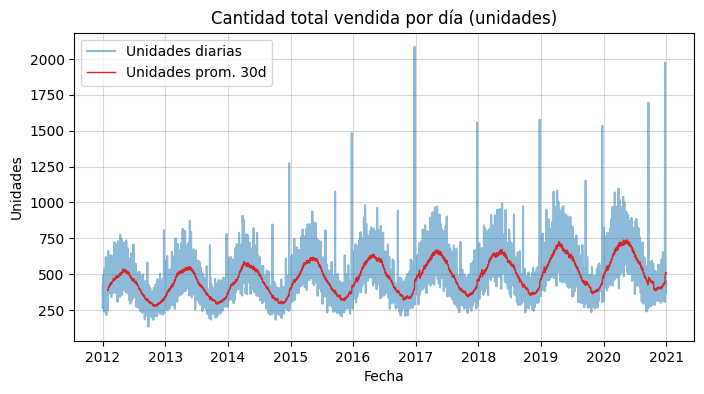

In [109]:

# Series de tiempo: agregamos transacciones a nivel diario (unidades y ventas).

#ordenasmos las ventas diarias, agrupando por fecha y suma de las cantidades vendidas en esa fecha
ventas_diarias = (
    df.groupby('Date')
      .agg(TotalUnidadesDia=('Quantity', 'sum'))
      .reset_index()
      .sort_values('Date')
)

# Medias móviles de 30 días en unidades y ventas
#PU30: Promedio unidades a 30 dias
#PV30: Promedio Ventas a 30 dias
ventas_diarias['PU30'] = ventas_diarias['TotalUnidadesDia'].rolling(window=30, min_periods=30).mean().shift(1)


#Resumen a grandes rasgos del CSV

resumen_unidades = {
    'Inicio operaciones': ventas_diarias['Date'].min().date(),
    'Final de operaciones': ventas_diarias['Date'].max().date(),
    'Promedio diario (unidades)': round(ventas_diarias['TotalUnidadesDia'].mean(), 0),
    'Máximo diario (unidades)': int(ventas_diarias['TotalUnidadesDia'].max()),
    'Mínimo diario (unidades)': int(ventas_diarias['TotalUnidadesDia'].min()),
}

print('Resumen de la serie diaria (unidades):')
for i, valor in resumen_unidades.items():
    print(f'  {i}: {valor}')

#Grafica Serie de tiempo con método medias moviles a 30 dias
#Unidades vendidas
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(ventas_diarias['Date'], ventas_diarias['TotalUnidadesDia'], label='Unidades diarias', alpha=0.5, color='tab:blue')
ax.plot(ventas_diarias['Date'], ventas_diarias['PU30'], label='Unidades prom. 30d', linewidth=1, color='tab:red')
ax.set_title('Cantidad total vendida por día (unidades)')
ax.set_xlabel('Fecha')
ax.set_ylabel('Unidades')
ax.legend()
ax.grid(alpha=0.5)
plt.show()

/var/folders/d9/2k27_l8j4kdf4z96lty3msz80000gn/T/ipykernel_20488/2506886598.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.groupby(pd.Grouper(key="Date", freq="M"))


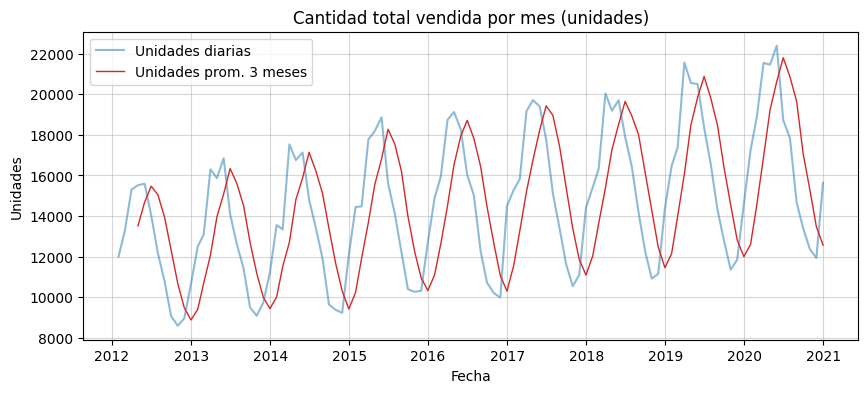

In [110]:
#Gráfico del mes a mes
ventas_mensuales = (
    df.groupby(pd.Grouper(key="Date", freq="M"))
      .agg(TotalUnidadesDia=('Quantity', 'sum'),
           TotalVentasDia=('TotalPrice', 'sum'))
      .reset_index()
      .sort_values('Date')
)
#media movil a 3 meses
ventas_mensuales['PU3'] = ventas_mensuales['TotalUnidadesDia'].rolling(window=3, min_periods=3).mean().shift(1)

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(ventas_mensuales['Date'], ventas_mensuales['TotalUnidadesDia'], label='Unidades diarias', alpha=0.5, color='tab:blue')
ax.plot(ventas_mensuales['Date'], ventas_mensuales['PU3'], label='Unidades prom. 3 meses', linewidth=1, color='tab:red')
ax.set_title('Cantidad total vendida por mes (unidades)')
ax.set_xlabel('Fecha')
ax.set_ylabel('Unidades')
ax.legend()
ax.grid(alpha=0.5)
plt.show()

Como podemos observar en los graficos, existe precencia de estacionalidad, en donde a nivel anual presentamos el mismo comportamiento en que las ventas suben significativamente hasta una fecha en particular y luego bajan con el mismo o muy similar grado.

2.  Dinámica de Productos (5 Puntos): Cree un único gráfico que muestre las series de tiempo de la Cantidad vendida para la “Leche Entera 1L” y el “Helado Chocolate Suizo 1L”. Compare y contraste visualmente los patrones de demanda de ambos. ¿Son sus tendencias y volatilidades similares?

/var/folders/d9/2k27_l8j4kdf4z96lty3msz80000gn/T/ipykernel_20488/4031711139.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .groupby([pd.Grouper(key='Date', freq='M'), 'ProductName'])['Quantity']


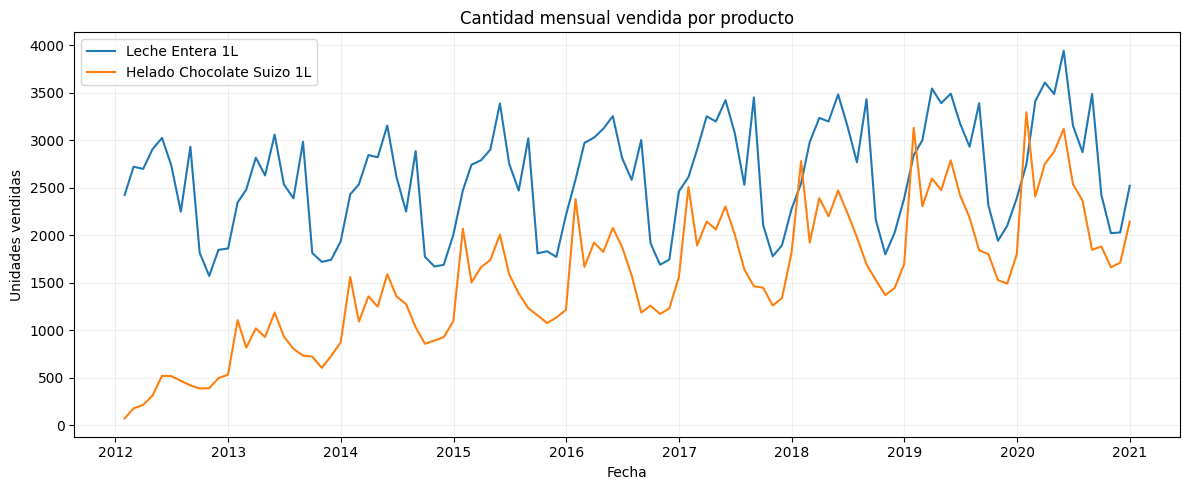

In [111]:
productos= ["Leche Entera 1L", "Helado Chocolate Suizo 1L"]
serie_productos = (
    df[df['ProductName'].isin(productos)]
    .groupby([pd.Grouper(key='Date', freq='M'), 'ProductName'])['Quantity']
    .sum()
    .reset_index()
    .sort_values('Date')
)

helado = serie_productos[serie_productos['ProductName'] == 'Helado Chocolate Suizo 1L']
leche = serie_productos[serie_productos['ProductName'] == 'Leche Entera 1L']

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(leche['Date'], leche['Quantity'], label='Leche Entera 1L')
ax.plot(helado['Date'], helado['Quantity'], label='Helado Chocolate Suizo 1L')

ax.set_title('Cantidad mensual vendida por producto')
ax.set_xlabel('Fecha')
ax.set_ylabel('Unidades vendidas')
ax.legend()
ax.grid(alpha=0.2)
plt.tight_layout()


Conclusiones:
Las ventas de leche mantienen volumenes altos y relativamente estables, en donde, si vemos de forma anual, esta suele tener 2 peaks por año, pero en promedio, una gran oscilación anual, popr lo que podemos decir que hay estacionalidad, ahora, esta estacionalidad parece ser aditiva, ya que la amplitud de las oscilaciones no se ve a simple vista un crecimiento significativo año a año. Luego, no se aprecian efectos de tendencia, esta es casi despreciable (constante).

En cuanto a las ventas de helado, podemos ver claramente efectos de tendecia, en donde a comienzos de 2012 posee una demanda baja y a medida que pasan los años, esta demanda va aumentando en promedio de manera aditiva. En cuanto a la estacionalidad, podiramos decir ue lleva una de forma multiplicatica, ya que año a año, posee oscilaciones con una amplitud mayor con el paso del tiempo. Estas oscilaciones parecen tener una correlacion negativa con respecto a las de la leche, pues, cuando la leche alcanza un peak, el helado alcanza un valle.

En cuanto a volatilidad, aparentemente el helado es más volatil, debido a su incremento en los ultimos años y que los peaks y valles de este, se forman de manera más abrupa a comparación de la Leche


3. Análisis de Estacionalidad (5 Puntos): Mediante gráficos de cajas (boxplots), ana- lice la distribución mensual de las ventas para la leche y el helado. ¿Qué meses presentan mayor y menor demanda para cada uno? ¿Confirman los gráficos la hipótesis de que el helado es un producto estacional y la leche es estable?

Leche Entera 1L: mayor mediana en Mayo (3387 unidades), menor en Octubre (1778 unidades)
Helado Chocolate Suizo 1L: mayor mediana en Enero (2380 unidades), menor en Octubre (1171 unidades)


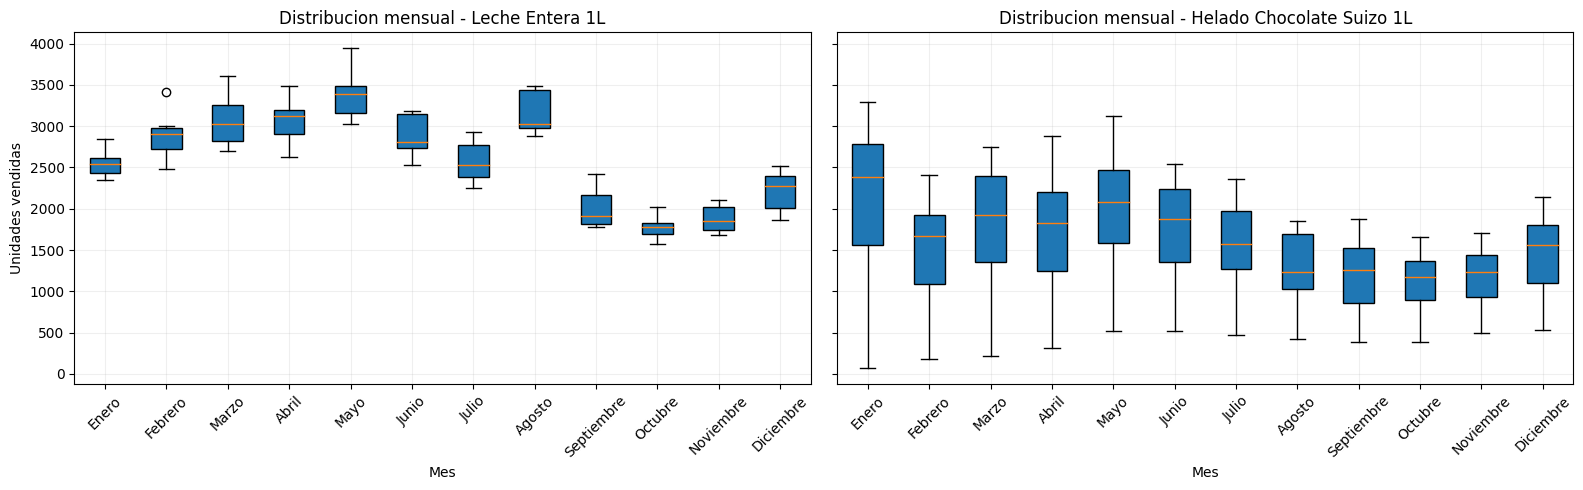

In [112]:

ventas_mensuales_productos= (
    df[df['ProductName'].isin(productos)]
    .groupby([pd.Grouper(key='Date', freq='MS'), 'ProductName'])['Quantity']
    .sum()
    .reset_index()
)

ventas_mensuales_productos['NroMes'] = ventas_mensuales_productos['Date'].dt.month
meses= ["Enero", "Febrero", "Marzo", "Abril", "Mayo", "Junio", "Julio", "Agosto", "Septiembre", "Octubre", "Noviembre", "Diciembre"]
ventas_mensuales_productos['MesNombre'] = ''
for i, mes in enumerate(meses, start=1):
    filas_mes = ventas_mensuales_productos['NroMes'] == i
    if filas_mes.any():
        ventas_mensuales_productos.loc[filas_mes, 'MesNombre'] = mes

fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharey=True)
for ax, producto in zip(axes, productos):
    datos_producto = ventas_mensuales_productos[ventas_mensuales_productos['ProductName'] == producto]
    datos_por_mes = [
        datos_producto.loc[datos_producto['MesNombre'] == mes, 'Quantity'].values
        for mes in meses
    ]
    ax.boxplot(datos_por_mes, labels=meses, patch_artist=True)
    ax.set_title(f'Distribucion mensual - {producto}')
    ax.set_xlabel('Mes')
    if ax is axes[0]:
        ax.set_ylabel('Unidades vendidas')
    else:
        ax.set_ylabel('')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(alpha=0.2)

plt.tight_layout()

resumen_medianas = (
    ventas_mensuales_productos
    .groupby(['ProductName', 'MesNombre'])['Quantity']
    .median()
    .unstack()
    .reindex(columns=meses)
)
for producto in productos:
    serie = resumen_medianas.loc[producto]
    mes_max = serie.idxmax()
    mes_min = serie.idxmin()
    print(f"{producto}: mayor mediana en {mes_max} ({serie.max():.0f} unidades), menor en {mes_min} ({serie.min():.0f} unidades)")



Conclusiones:
Como podemos ver, en el boxplot de la leche, se observa una disperción poco variable,  las cajas más comprimidas significa que posee ventas más estables, las medianas dicen además que sus ventas suben hasta mediado de año y luego vuelven a bajar.

En cuanto al helado Las cajas son más altas y los bigotes más largos Por lo que existe una gran variabilidad de sus ventas, además los "bigotes" largos que posee implica ventas irregulares y sensibles a factores externos, como es de esperar de un producto como el helado.

Los graficos respaldan que el helado es altamente estacional mientras la leche presenta demanda mas estable y predecible.

## 2. Preparación de Datos


1. Agregación Temporal (3 Puntos): Agregue los datos a una frecuencia temporal regular (diaria, semanal o mensual). Justifique la elección de la frecuencia, considerando el balance entre granularidad y interpretabilidad para productos de retail.


In [113]:
#Dado que en el siguiente item, en donde armamos el modelo, 
# trabajaremos solo con el producto Leche Entera 1L, extraeremos solo la info de ese producto
ventas_leche_mensual = (
    df[df['ProductName'] == "Leche Entera 1L"]
    .set_index('Date')[['Quantity', 'TotalPrice']]
    .resample("M") #frecuencia semanal para entrenar al modelo
    .sum()
    
    .reset_index()
)

print("Ventas de Leche entera primeros 5 meses:")
print(ventas_leche_mensual.head())

Ventas de Leche entera primeros 5 meses:
        Date  Quantity  TotalPrice
0 2012-01-31      2424     2302800
1 2012-02-29      2721     2584950
2 2012-03-31      2698     2563100
3 2012-04-30      2904     2758800
4 2012-05-31      3024     2872800


/var/folders/d9/2k27_l8j4kdf4z96lty3msz80000gn/T/ipykernel_20488/2487885431.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M") #frecuencia semanal para entrenar al modelo


Hasta ahora habiamos trabajado de manera mensual para la visualización exploratia de datos, esto ayudó a visualizar con poco ruido la información y hacer analisis sencillos. Por otro lado, pensamos en utilizar para entrenar al modelo un esquema semanal ya que así tenemos más datos para entrenar el modelo conservando el patrón estacional, pero considerando el contexto de la base de datos, en donde se venden productos de retail, condiremos seguir trabajando de forma mensual, ya que para efectos de estacionalidad, es más facil comparar un mes del periodo anterior (año anterior) a una semana del periodo anterior, claramente es más significativo un mes para este efecto, por lo que si bien tendremos menos datos para entrenar el modelo, estos datos serán más significativos. Además, para ventas de retail es más útil saber un pronóstico del proóximo mes, que de la próxima semana, pues así es más facil planificar ventas, compras e incluso metas.


2. División de Muestras (2 Puntos): Segmente su serie de tiempo en un conjunto de entrenamiento (primer 80 % de los datos) y uno de prueba (20 % final). Explique por qué esta división es fundamental para una evaluación objetiva del rendimiento del modelo.

In [114]:
cant_registros_mes = len(ventas_leche_mensual)
cant_train_mes = int(cant_registros_mes * 0.8)
ventas_train_mes = ventas_leche_mensual.iloc[:cant_train_mes].copy()
ventas_test_mes = ventas_leche_mensual.iloc[cant_train_mes:].copy()

print(f"En nuestro dataset, tenemos {cant_registros_mes} registros")
print(f"Por lo que usaremos el 80% de ellos para entrenar el modelo, es decir {cant_train_mes} datos")
print(f"El resto será de prueba, es decir {cant_registros_mes - cant_train_mes} datos (último 20%)")

En nuestro dataset, tenemos 108 registros
Por lo que usaremos el 80% de ellos para entrenar el modelo, es decir 86 datos
El resto será de prueba, es decir 22 datos (último 20%)


Utilizar el 80% de los datos para entrenar el modelo permitirá que este tenga una gran cantidad de información para entender el comportamiento de las ventas. Luego, es necesario dejar un porcentaje restante para poder probar el modelo a ver si este logra predecir los datos reales y poder obtener métricas de accuracy para entender qué tanto acierta el modelo.


## 3. Modelamiento y Pronóstico (25 Puntos)

1. Justificación del Modelo (5 Puntos): Describa el modelo de pronóstico que ha elegido. Basándose en los hallazgos del análisis exploratorio (tendencia, estacionalidad), explique por qué este modelo es adecuado para el producto seleccionado. Explique cómo determinó los parámetros clave del modelo.

La leche: El modelo Holt-Winters (alisado exponencial triple aditivo) se justifica porque la serie presenta un patrón estacional claramente repetitivo. Este método permite modelar la estacionalidad y la variabilidad, a diferencia de los dempas modelos vistos que no tienen una componente de estacionalidad. 

Probaremos este modelo bajo varias configuraciones diferentes para determinar cuál se ajusta mejor a los datos. A partir de los gráficos anteriores, suponemos que el modelo aditivo funciona mejor que el multiplicativo para las ventas de leche. En cuanto a la tendencia, se puede observar un leve movimiento ascendente, por lo que para asegurar unn buen ajuste del pronóstico, consideraremos tendecia aditiva en vez de nula.

Para construir el modelo de Holt-Winters, primero necesitamos calcular los parámetros estacionales 𝑐𝑡 para el primer ciclo de datos, es decir, el primer año. Esto se hace dividiendo las ventas de cada mes por el promedio anual. A partir de estos parámetros, se pueden estimar los parámetros de nivel 𝑆𝑡 para los períodos siguientes dividiendo las ventas por el parámetro estacional correspondiente 𝑐𝑡 del mismo mes o semana del ciclo anterior. El parámetro de tendencia puede estimarse restando las razones entre las ventas y los parámetros estacionales de dos períodos diferentes, por ejemplo entre el período 12 y el período 1. Después de estas estimaciones iniciales, los parámetros de los períodos siguientes se calculan utilizando las ecuaciones de Holt-Winters y valores iniciales para los coeficientes de suavizado 𝛼, 𝛽 y γ. Los valores iniciales típicos pueden ser (0.1, 0.1, 0.1) o (0.2, 0.1, 0.1). El objetivo del modelo es optimizar estos parámetros para minimizar los errores de predicción. Esto es precisamente lo que ocurre al usar la función ExponentialSmoothing.

La función ExponentialSmoothing en Python, de la biblioteca statsmodels, se utiliza para construir un modelo de Holt-Winters que capta el nivel, la tendencia y la estacionalidad de una serie temporal. Al llamarla con parámetros como trend, seasonal y seasonal_periods, se define la estructura del modelo. La función estima valores como: los coeficientes de suavizado alfa, beta y gamma, que determinan cuánto influyen las nuevas observaciones en el nivel, la tendencia y los componentes estacionales estimados, así como los estados iniciales como el primer nivel, la primera tendencia y el primer ciclo estacional. Una vez ajustado, el modelo produce tanto valores ajustados para el período observado como pronósticos para períodos futuros.

Cuando se usa el argumento optimized=True, la función selecciona automáticamente los valores de alfa, beta y gamma (y los estados iniciales) que minimizan la suma de los errores cuadráticos de un paso hacia adelante, conocida como SSE (Sum of Squared Errors). Matemáticamente, la función minimiza:

SSE(θ) = Σ (y_t − ŷ_t|t−1(θ))²,

donde θ representa todos los parámetros del modelo. La optimización combina normalmente una búsqueda en cuadrícula gruesa (si use_brute=True) para encontrar buenos puntos de partida, considerando parámetros dentro de límites válidos entre 0 y 1.

Minimizar la SSE es equivalente a minimizar el error cuadrático medio (MSE) o la raíz del error cuadrático medio (RMSE), ya que estas medidas difieren solo por un factor constante o una raíz cuadrada. Para un número fijo de observaciones n,

MSE = SSE / n y RMSE = √(SSE / n).

Por lo tanto, los valores de los parámetros que minimizan la SSE también minimizan el RMSE. En otras palabras, el modelo se ajusta de modo que el cuadrado de sus errores de predicción sea lo más pequeño posible, y el RMSE que luego calculamos a partir de las predicciones es simplemente una versión reescalada de la misma función objetivo.

2. Implementación y Entrenamiento (8 Puntos): Implemente el modelo elegido en Python, R o Excel. Entrene el modelo utilizando exclusivamente el conjunto de datos de entrenamiento.

#  Modelo basado sobre los datos en meses

In [115]:

from statsmodels.tsa.holtwinters import ExponentialSmoothing
#from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#import seaborn as sns



In [116]:
#Primero creamos dos nuevos dataframes que pueden ser utilizados por nuestro modelo de Holt-Winters.
#Estos dataframes están compuestos únicamente por los atributos de fecha (por mes) y cantidad.

y_train_mes = ventas_train_mes.set_index("Date")["Quantity"].asfreq("M", fill_value=0)
y_test_mes  = ventas_test_mes.set_index("Date")["Quantity"].asfreq("M", fill_value=0)

/var/folders/d9/2k27_l8j4kdf4z96lty3msz80000gn/T/ipykernel_20488/3233889747.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  y_train_mes = ventas_train_mes.set_index("Date")["Quantity"].asfreq("M", fill_value=0)
/var/folders/d9/2k27_l8j4kdf4z96lty3msz80000gn/T/ipykernel_20488/3233889747.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  y_test_mes  = ventas_test_mes.set_index("Date")["Quantity"].asfreq("M", fill_value=0)


In [117]:
#entrenamos el modelo con datos de entrenamiento
Model1 = ExponentialSmoothing(
    y_train_mes,        #Dataset de entrenamiento
    trend="add",             # Gt, Componente de tendencia, usar None si no hay tendencia
    seasonal="add",          # Componente de estacionalidad ct, use "mul" if seasonality scales with level
    seasonal_periods=12     #cada cuanto hay un periodo ct
).fit(optimized=True, use_brute=True)  # brute grid first helps avoid local minima

print("Parámetros ajustados:", Model1.params)

Parámetros ajustados: {'smoothing_level': 0.10862951192570565, 'smoothing_trend': 0.09455970037301735, 'smoothing_seasonal': 0.06972491618701367, 'damping_trend': nan, 'initial_level': 2382.1462699481363, 'initial_trend': -1.395940655914992, 'initial_seasons': array([  -5.52624953,  241.73724957,  429.92136193,  436.67531692,
        735.02321373,  261.5081841 ,  -77.8740676 ,  548.33376908,
       -633.87734303, -805.38908985, -722.26816875, -411.93845657]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


smothing_level hace referencia a nuestro alpha, utilizado en la base de la serie (St). En este caso  0.1110714500185621

smoothing_trend hace referencia a nuestro betha, utilizado en Gt, la componente de tendencia. En este caso: 0.09873017491563299.

smoothing_seasonal hace referencia a nuestro gama, utilizado en ct, la componente de estacionalidad. En este caso: 0.00010000574688345366.

Luego, initial_level, initial_trend vendrian siendo S0 y G0, en este caso 2385.769428203602 y 1.0013880805432596.  


## 3. Evaluación Cuantitativa (8 Puntos):


1. Genere un pronóstico para el período que cubre el conjunto de prueba.

In [118]:
#Generamos el pronóstico para el período de prueba.
y_pred_1 = Model1.forecast(len(y_test_mes))
y_pred_1.index=y_test_mes.index


2. Calcule al menos tres métricas de error (ej. MSE, MAE, RMSE, MAPE) para su modelo. Presente los resultados en una tabla y comente sobre el rendimiento


In [119]:
#Comparando el valor obtenido con la función y con la fórmula explícita.
#Asegúrate de que las dos series estén alineadas y tengan la misma longitud.

n = len(y_test_mes)
mae_manual = (abs(y_test_mes - y_pred_1)).sum() / n

rmse_manual = np.sqrt(((y_test_mes - y_pred_1)**2).sum() / n)

mask = y_test_mes != 0  # para evitar dividir por cero
n_valid = mask.sum()  # observaciones válidas

mape_manual = (abs((y_test_mes[mask] - y_pred_1[mask]) / y_test_mes[mask])).sum() / n_valid * 100


print(f"MAE (manual): {mae_manual:.2f}")
print(f"RMSE (manual): {rmse_manual:.2f}")
print(f"MAPE (manual): {mape_manual:.2f}%")




MAE (manual): 121.11
RMSE (manual): 153.36
MAPE (manual): 4.07%


In [120]:
#Presentación de los errores como tabla

error_table = pd.DataFrame({
    'Metric': ['MAE', 'RMSE', 'MAPE'],
    'Value': [mae_manual, rmse_manual, f"{mape_manual:.2f}%"]
})

print(error_table)

  Metric      Value
0    MAE  121.10733
1   RMSE  153.36007
2   MAPE      4.07%


4. Visualización del Pronóstico (4 Puntos): Cree un gráfico que muestre la serie
de tiempo real (entrenamiento y prueba) y superponga el pronóstico generado por su modelo sobre el período de prueba.

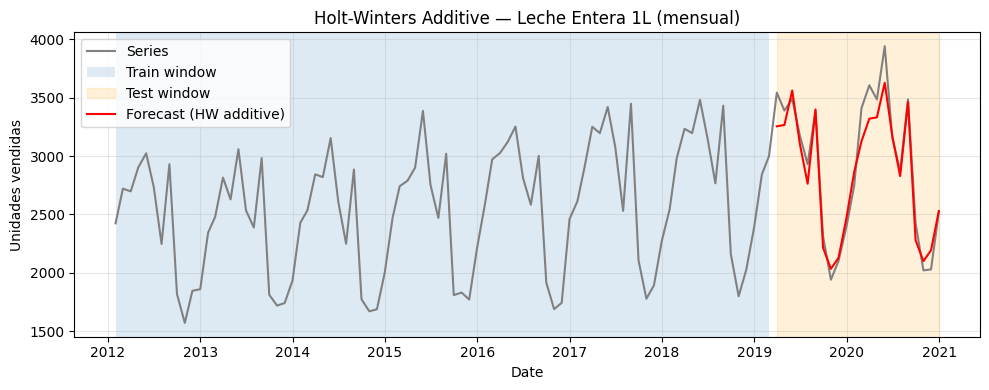

In [121]:
plt.figure(figsize=(10,4))
y_all = pd.concat([y_train_mes, y_test_mes])
plt.plot(y_all.index, y_all, color='gray', label='Series')
plt.axvspan(y_train_mes.index[0], y_train_mes.index[-1], alpha=0.15, label='Train window')
plt.axvspan(y_test_mes.index[0],  y_test_mes.index[-1],  alpha=0.15, color='orange', label='Test window')
plt.plot(y_pred_1.index,  y_pred_1,  label='Forecast (HW additive)', color='red')

plt.title('Holt-Winters Additive — Leche Entera 1L (mensual)')
plt.xlabel('Date')
plt.ylabel('Unidades vendidas')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 4. Análisis de Negocio y Recomendaciones (15 Puntos)

La etapa final es traducir los resultados técnicos en información accionable para el negocio.


1. Proyección a Futuro (5 Puntos): Utilizando su modelo final (re-entrenado con todos
los datos), genere un pronóstico de demanda para los próximos 12 meses para el producto que modeló.

In [ ]:
# Re-entrenar el modelo Holt-Winters con todos los datos mensuales y proyectar 12 meses
leche_full = (
    df[df['ProductName'] == "Leche Entera 1L"]
    .set_index('Date')['Quantity']
    .sort_index()
    .resample('ME')
    .sum()
)
leche_full = leche_full.asfreq('ME')

final_hw_model = ExponentialSmoothing(
    leche_full,
    trend='add',
    seasonal='mul',
    seasonal_periods=12
).fit(optimized=True)

forecast_horizon = 12
forecast_values = final_hw_model.forecast(forecast_horizon)
forecast_index = pd.date_range(
    start=leche_full.index[-1] + pd.offsets.MonthEnd(1),
    periods=forecast_horizon,
    freq='ME'
)
forecast_values.index = forecast_index

forecast_df = (
    forecast_values.round(2)
    .rename('Forecast_Quantity')
    .to_frame()
)
forecast_df.index.name = 'Date'

display(forecast_df)


2. Recomendaciones de Inventario (5 Puntos): Basándose en su pronóstico, ¿qué recomendación le daría al gerente de la cadena sobre los niveles de stock de seguridad para la “Leche Entera 1L” y el “Helado Chocolate Suizo 1L” a lo largo del año? Sea específico (ej. “aumentar stock de helado en un X % entre noviembre y febrero”).


3. Recomendación Estratégica (5 Puntos): Si la gerencia quisiera diseñar una cam-
paña de marketing para “desestacionalizar” la venta de helado y aumentar su consumo en los meses de baja demanda, ¿en qué meses sugeriría lanzar una promoción (ej. “2x1 en helados”)? Justifique con base en su análisis.